## LeNet

In [19]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

In [20]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from 'e:\\Programming\\Python\\Learning_MachineLearning\\DL\\utils.py'>

In [21]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [22]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output_shape:\t', X.shape)

Conv2d output_shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output_shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output_shape:	 torch.Size([1, 6, 14, 14])
Conv2d output_shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output_shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output_shape:	 torch.Size([1, 16, 5, 5])
Flatten output_shape:	 torch.Size([1, 400])
Linear output_shape:	 torch.Size([1, 120])
Sigmoid output_shape:	 torch.Size([1, 120])
Linear output_shape:	 torch.Size([1, 84])
Sigmoid output_shape:	 torch.Size([1, 84])
Linear output_shape:	 torch.Size([1, 10])


In [23]:
batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root='./data', train=True, transform=transform,
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, transform=transform,
)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval() # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    metric = utils.Accumulator(2)  # num_corrected_examples, num_examples
    # ? no_grad()?
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(utils.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs], 
                              legend=['train_loss', 'train acc', 'test acc'])
    timer, num_batches = utils.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, num of examples
        metric = utils.Accumulator(3)
        net.train()
        # train one batch
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # ? no_grad()?
            with torch.no_grad():
                metric.add(l * X.shape[0], utils.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # draw
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                # the horizontal axis unit is epoch
                animator.add(epoch + (i + 1) / num_batches, 
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, ',
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec ',
          f'on {str(device)}')

loss 0.427, train acc 0.843,  test acc 0.822
12833.9 examples/sec  on cuda:0


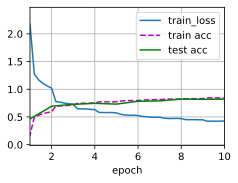

In [26]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())

## AlexNet

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

In [27]:
X = torch.randn(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

loss 0.332, train acc 0.879,  test acc 0.884
1393.4 examples/sec  on cuda:0


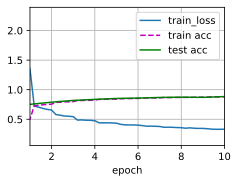

In [19]:
batch_size = 128
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='./data', train=True, transform=transform,
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, transform=transform,
)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lr, num_epochs = 0.01, 10
train(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())

## GoogLeNet

In [28]:
from torch.nn import functional as F

In [29]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # path 1
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # path 2
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # path 3
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # path 4
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        # concatenate on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                    Inception(512, 160, (112, 224), (24, 64), 64),
                    Inception(512, 128, (128, 256), (24, 64), 64),
                    Inception(512, 112, (144, 288), (32, 64), 64),
                    Inception(528, 256, (160, 320), (32, 128), 128),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                    Inception(832, 384, (192, 384), (48, 128), 128),
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten())
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

loss 0.246, train acc 0.906,  test acc 0.876
1337.0 examples/sec  on cuda:0


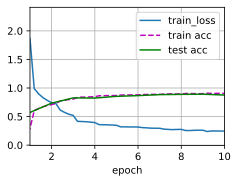

In [30]:
batch_size = 128
transform = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True,
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, transform=transform, download=True,
)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lr, num_epochs = 0.1, 10
train(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())

## ResNet

In [31]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        # prediction mode: the mean and std of the whole dataset is known
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else: 
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # full connection layer
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # convolutional layer: batchsize, channel, height, width
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            # keep the dimension of channel
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super.__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # scale and shift parameter initia 
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # global mean and variance
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, 
            eps=1e-5, momentum=0.9
        )
        return Y
        

In [32]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
# the same size
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [33]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [34]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size =3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    # number of the residual block
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)), 
                    nn.Flatten(), nn.Linear(512, 10))

loss 0.015, train acc 0.996,  test acc 0.889
1719.6 examples/sec  on cuda:0


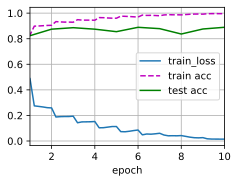

In [35]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())